<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-03/ex03_cnn_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Language Identification (Reloaded and Convoluted)
## 1. Setup
### 1.1 Dependencies

In [ ]:
!pip install talos

In [ ]:
!pip install demoji

In [ ]:
!pip install googletrans==4.0.0rc1


### 1.2 Imports

In [69]:
import csv
import re
from io import StringIO
import requests
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
import warnings
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping

#import talos
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

from googletrans import Translator
translator = Translator()

import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### 1.2 Environment

In [ ]:
# Check if device supports CUDA interface
CUDA = torch.cuda.is_available()
# Make program run on gpu (cuda:0) if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
torch.cuda.set_device(device)
print('Using device:', device)

Using device: cuda:0


In [ ]:
# Check and print information about available GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 26 17:57:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-33ed3149-e1cb-65ff-04b8-d1ed1ce43f25)


In [ ]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### 1.4 Constants

In [3]:
TARGET_COLUMN = 'label'
TWEET_COLUMN = 'tweet'
SAMPLE_THRESHOLD = 20

## 2. Data Acquisition

In [10]:
url_train = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [8]:
def load_dataset(url):
  r = requests.get(url)
  data = r.content.decode('utf8')
  df = pd.read_csv(StringIO(data), sep='\t')
  df.columns = ['tweet', 'label']
  return df

In [11]:
df_train = load_dataset(url_train)
df_test = load_dataset(url_test)

In [12]:
dataset = pd.concat([df_train, df_test], axis=0) # Merge into one dataset for the pre-processing

In [13]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(df_train), len(df_test), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [15]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [16]:
dataset.head(10) # Show some sample tweets

,tweet,label
0,Stay On Twitter \=D/,en
1,@Eliass_RC y si no quiero que?,es
2,"Aimes tu porter un petit costard, nœud pap et ...",fr
3,@DirtyyDream abi allahin adini verdim tw da pa...,tr
4,Robben #11!,und
5,鳥肌,ja
6,"@michaela_cain25 He started saying ""Theresa yo...",en
7,Я прошел квест 'Расчистить островок.' в The Tr...,ru
8,Apakah aku harus menunggu lama seperti ini yg ...,id
9,@ms_ryame 😂😂😂😂😂🌚,und


## 3. Data Exploration

In [17]:
def data_exploration(df):
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("Dataset contains the columns: {}".format(list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

In [35]:
# This function checks which lanugages occur in the full dataset less than 'SAMPLE_THRESHOLD' times.
# These languages are then returned as the list of underrepresented languages
def get_underrepresented_languages(df, target_column, sample_threshold):
    df = df.groupby(target_column).size().to_frame().reset_index(drop=False).rename(columns={0: 'occurences'})
    underrepresented_languages = list(df[df['occurences'] < SAMPLE_THRESHOLD][target_column])
    return underrepresented_languages

In [19]:
def print_number_of_underrepresented_languages(df, target_column, sample_threshold):
  underrepresented_languages = get_underrepresented_languages(df, target_column, sample_threshold)
  print("There are {} languages in this data set with less then {} samples.".format(len(underrepresented_languages), sample_threshold))

Dataset contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


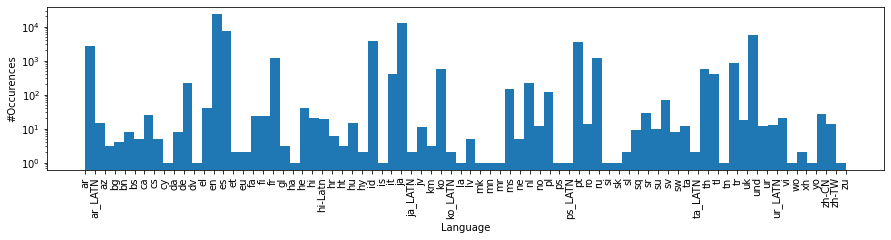

In [20]:
data_exploration(dataset)

In [21]:
print_number_of_underrepresented_languages(dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [34]:
# Display all languages and their absolute number off occurences in descending order
language_count=dataset[TARGET_COLUMN].value_counts().reset_index()
language_count
df = pd.DataFrame(language_count)
df.columns = ['language', 'occurences']
df

,language,occurences
0,en,23266
1,ja,12899
2,es,7406
3,und,5766
4,id,3823
5,pt,3577
6,ar,2728
7,ru,1221
8,fr,1170
9,tr,843


## 4. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model. We decided to transform our corpus into lowercase, since the case wont have
a big influence on the language classification performance

In [36]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [48]:
def clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [51]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(dataset[TARGET_COLUMN]))
for language in languages:
  localized_tweets = dataset[dataset[TARGET_COLUMN] == language]
  # Clean and compare them
  cleaned_localized_tweets = clean_data(localized_tweets, TWEET_COLUMN)
  comparison_view = pd.concat([localized_tweets.drop([TARGET_COLUMN], axis=1), cleaned_localized_tweets], axis=1)
  print(comparison_view.head(5))
  #print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                                 tweet                                              tweet label
29   @mohamadapont صدقي العزيز أنا أتفق .. لاكن أظن...   صدقي العزيز أنا أتفق  لاكن أظن سبب فوز ميسي  ...    ar
41   @Salnamani يااسلااااام  احلى الشي الريف🌳🌳والطب...   يااسلااااام  احلى الشي الريفوالطبيعه الخلابه ...    ar
56   اللهم أغفر لنا ذنوبنا وارحمنا برحمتك يا أرحم ا...  اللهم أغفر لنا ذنوبنا وارحمنا برحمتك يا أرحم ا...    ar
103                               @Nouf__455 خبله انتي                                          خبله انتي    ar
129                  @shalabito  الثقة الاعمياء قتلتني                              الثقة الاعمياء قتلتني    ar
---
                                                   tweet                                          tweet    label
6154                            Roo7y 3oomy fi ter3a 😂😂😂                             rooy oomy fi tera   ar_LATN
7587           @Sousou_Officiel wach hkayatha hadi Lucia                       wach hkayatha hadi 

In [105]:
cleaned_dataset = clean_data(dataset, TWEET_COLUMN)

In [106]:
# Check that the dataset does not contain null values
cleaned_dataset.isnull().values.any() 

False

## 5.Data Augmentation
We consider languages which have less then 20 sample tweets in the dataset as infrequent. You can either remove these infrequent languages or use augmentation or upsampling techniques to increase the language frequency.
We decided to use back translation in order to keep infrequent languages but increase their frequency.


In [107]:
def back_translation(df,target_languages=['en']):
  translated_data = pd.DataFrame(columns={TWEET_COLUMN, TARGET_COLUMN})
  for target_language in target_languages:
    for index, row in df.iterrows():
      try:
        tweet = row[TWEET_COLUMN]
        source_language = row[TARGET_COLUMN]
        translated_data=translated_data.append({'tweet': translator.translate(translator.translate(tweet, dest=target_language).text, dest=source_language).text, 'label': source_language}, ignore_index=True)
      except Exception as e:
        print(e)
        pass
  return translated_data

In [108]:
print_number_of_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [109]:
underrepresented_languages = get_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)
print(underrepresented_languages)

['ar_LATN', 'az', 'bg', 'bn', 'bs', 'cs', 'cy', 'da', 'dv', 'et', 'eu', 'gl', 'ha', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'is', 'ja_LATN', 'jv', 'km', 'ko_LATN', 'la', 'lv', 'mk', 'mn', 'mr', 'ne', 'no', 'ps', 'ps_LATN', 'ro', 'si', 'sk', 'sl', 'sq', 'su', 'sw', 'ta', 'ta_LATN', 'tn', 'uk', 'ur', 'ur_LATN', 'wo', 'xh', 'yo', 'zh-TW', 'zu']


In [113]:
# Increasing the number of rare languages by backtranslation
upsampled_dataset = cleaned_dataset.copy()

for l in underrepresented_languages:
  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
  upsampled_dataset.drop(upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l].index, inplace = True, axis=0)
  len_first = len(underrepresented_language)

  if not l.endswith('latn'): # Only run the upsamling for non latn languages
    underrepresented_language = pd.concat([underrepresented_language, back_translation(underrepresented_language)], axis=0) # run back translation
  
  len_second = len(underrepresented_language)
  if(len_second < SAMPLE_THRESHOLD):
    underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
  len_third = len(underrepresented_language)
  
  print("({0}): #{1}=>back_translation=>#{2}=>resampling=>#{3}".format(l, len_first, len_second, len_third))
  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'
'Translator' object has no attribute 'raise_Exception'


KeyboardInterrupt: ignored

In [103]:
upsampled_dataset.reset_index(drop=True)

,tweet,label
0,Stay On Twitter \=D/,en
1,@Eliass_RC y si no quiero que?,es
2,"Aimes tu porter un petit costard, nœud pap et ...",fr
3,@DirtyyDream abi allahin adini verdim tw da pa...,tr
4,Robben #11!,und
...,...,...
66723,@Official_SABC1 Moloooo nakuwe!!!,zu
66724,@Official_SABC1 Moloooo nakuwe!!!,zu
66725,@ Official_Sabc1 Molooooo nawe !!!,zu
66726,@Official_SABC1 Moloooo nakuwe!!!,zu


In [77]:
upsampled_dataset.to_pickle('./dataset.pkl') # Save dataset as compact pkl file
upsampled_dataset.to_csv('./dataset.csv', header=True, index=False) # Save dataset as easily accessible csv file

In [82]:
# Check that no underrepresented languages exists anymore in the dataset
# The list of underrepresented languages needs to be empty now
get_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

[]

In [80]:
print_number_of_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 0 languages in this data set with less then 20 samples.


In [81]:
print("The length of the upsampled dataset is {}.".format(len(upsampled_dataset)))

The length of the upsampled dataset is 66728.


## Tokenize the data

In [ ]:
tokenize_data = Tokenizer(num_words=None,char_level=True,oov_token = 'UNK')

In [ ]:
tokenize_data.fit_on_texts(all_training_tweets)

In [ ]:
vectorized_training_data = tokenize_data.texts_to_sequences(all_training_tweets)
vectorized_testing_data = tokenize_data.texts_to_sequences(all_test_tweets)

In [ ]:
padding_length=80
train_data = pad_sequences(vectorized_training_data, maxlen=padding_length, padding='post')
test_data = pad_sequences(vectorized_testing_data, maxlen=padding_length, padding='post')

# Converting label to dictionary

In [95]:
label2index = {label:index for label,index in enumerate(dataset[TARGET_COLUMN].unique())}

In [ ]:
df_train_dev['label_index'] = df_train_dev['label'].apply(lambda x: label_index_mapping[x])
df_test['label_index'] = df_test['label'].apply(lambda x: label_index_mapping[x])

In [ ]:
df_train_dev

,tweet,label,label_index
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع أ...,ar,0
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar,0
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar,0
3,يا ابو سلو عرفتني,ar,0
4,ب ريال أكفل معتمر في رمضان ، ولك بإذن الله مثل...,ar,0
...,...,...,...
52320,,und,20
52321,via,und,20
52322,"pagi min selamat pagiii prillverssnice dayy*""",und,20
52323,,und,20


In [ ]:
train_labels = df_train_dev['label_index'].values
type(train_labels)

numpy.ndarray

In [ ]:
train_labels = df_train_dev['label_index'].values
train_label_list = [x for x in train_labels]

test_labels = df_test['label_index'].values
test_label_list = [x for x in test_labels]

In [ ]:
from keras.utils import to_categorical
train_classes_categorical = to_categorical(train_labels)
test_classes_categorical = to_categorical(train_labels)

### Splitting the dataset into training & verification datasets

In [ ]:
vocab_size = len(tokenize_data.word_index)
padding_length, 
embedding_dim = 50

## Creating CNN 

In [ ]:
loss = "categorical_crossentropy"
epochs = 100
verbose = 1
def langIDCNN(X_train, y_train, X_val, y_val, hyperparameters):
  print(params['dropout'])
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=7)
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=padding_length))
  model.add(Dropout(params['dropout']))
  model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], strides=params['strides'], padding='valid', activation='relu'))
  model.add(params['pooling'])
  model.add(Dense(params['hidden_dims']))
  model.add(Dropout(params['dropout']))
  model.add(Activation('relu'))
  model.add(Dense(len(set(train_label_list))))
  model.add(Activation('softmax'))
  model.compile(optimizer=params['optimizer'], loss=loss, metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, params['learning_rate'])

  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=params['batch_size'], epochs=epochs, verbose=verbose,  callbacks = [es]) 

  return history, model

## 

In [ ]:
hyperparameters_1 = {
    'dropout': (0.5),
    'filters': (128),
    'kernel_size': (3),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (128),
    'learning_rate': (0.01),
    'batch_size': (100),
    'optimizer': ('adam')
}

In [ ]:
history_1, model_1 = langIDCNN(moX_train,y_train,X_val,y_val)

0.5
Epoch 1/100
471/471 [==============================] - 4s 8ms/step - loss: 0.8080 - accuracy: 0.7583 - val_loss: 0.4448 - val_accuracy: 0.8666
Epoch 2/100
471/471 [==============================] - 3s 7ms/step - loss: 0.5778 - accuracy: 0.8301 - val_loss: 0.4110 - val_accuracy: 0.8813
Epoch 3/100
471/471 [==============================] - 3s 7ms/step - loss: 0.5503 - accuracy: 0.8418 - val_loss: 0.3671 - val_accuracy: 0.8876
Epoch 4/100
471/471 [==============================] - 3s 7ms/step - loss: 0.5257 - accuracy: 0.8494 - val_loss: 0.4030 - val_accuracy: 0.8865
Epoch 5/100
471/471 [==============================] - 4s 7ms/step - loss: 0.5296 - accuracy: 0.8521 - val_loss: 0.4055 - val_accuracy: 0.8878
Epoch 6/100
471/471 [==============================] - 3s 7ms/step - loss: 0.5306 - accuracy: 0.8519 - val_loss: 0.3937 - val_accuracy: 0.8909
Epoch 7/100
471/471 [==============================] - 3s 7ms/step - loss: 0.5159 - accuracy: 0.8541 - val_loss: 0.3852 - val_accuracy: 0.

## Evaluation of model with parameter -1

In [ ]:
returned_model.evaluate(test_data,test_classes_categorical)


1636/1636 [==============================] - 4s 3ms/step - loss: 0.3524 - accuracy: 0.8997


[0.35241401195526123, 0.8997228741645813]

In [ ]:
returned_history.history

{'val_loss': [0.5035257344817643,
  0.4310805834389533,
  0.39706229949401983,
  0.42411727414211153,
  0.4077531506985233,
  0.40321258334226384,
  0.42943673628889056,
  0.43483962987244607,
  0.4845301331430276,
  0.4650332004206807],
 'val_accuracy': [0.8568432927131653,
  0.88181471824646,
  0.8867708444595337,
  0.886580228805542,
  0.8940144777297974,
  0.8964925408363342,
  0.8907739520072937,
  0.895348846912384,
  0.8888677358627319,
  0.8938238620758057],
 'loss': [0.8317834391534145,
  0.5919428705542961,
  0.554838399786696,
  0.5387479307339622,
  0.5237933242430088,
  0.5116659333691056,
  0.5239955166739582,
  0.5117973383151071,
  0.5201408492517465,
  0.5022770777706391],
 'accuracy': [0.76146907,
  0.82784766,
  0.8392426,
  0.8481383,
  0.85489476,
  0.85752106,
  0.8566103,
  0.8580506,
  0.85709745,
  0.861397]}

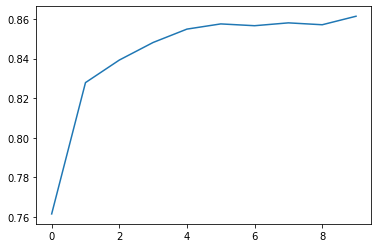

In [ ]:
plt.plot(returned_history.history['accuracy'])
# plt.plot(langIDCNN.history['val_acc'])

## HyperParameter set-2 for CNN

In [ ]:
params1 = {
    'dropout': (0.8),
    'filters': (256),
    'kernel_size': (7),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (128),
    'learning_rate': (0.01),
    'batch_size': (100),
    'optimizer': ('SGD')
}
loss = "categorical_crossentropy"
epochs = 100

In [ ]:
returned_history1,returned_model1 = langIDCNN(X_train,y_train,X_val,y_val,params1)

0.8
Epoch 1/100
471/471 [==============================] - 3s 7ms/step - loss: 2.4158 - accuracy: 0.3237 - val_loss: 2.2742 - val_accuracy: 0.3522
Epoch 2/100
471/471 [==============================] - 3s 6ms/step - loss: 2.1448 - accuracy: 0.3625 - val_loss: 2.1408 - val_accuracy: 0.3522
Epoch 3/100
471/471 [==============================] - 3s 6ms/step - loss: 2.0219 - accuracy: 0.4245 - val_loss: 2.0446 - val_accuracy: 0.3889
Epoch 4/100
471/471 [==============================] - 3s 6ms/step - loss: 1.9031 - accuracy: 0.4747 - val_loss: 1.9479 - val_accuracy: 0.4944
Epoch 5/100
471/471 [==============================] - 3s 6ms/step - loss: 1.8163 - accuracy: 0.4997 - val_loss: 1.8681 - val_accuracy: 0.5249
Epoch 6/100
471/471 [==============================] - 3s 6ms/step - loss: 1.7582 - accuracy: 0.5111 - val_loss: 1.7949 - val_accuracy: 0.5326
Epoch 7/100
471/471 [==============================] - 3s 6ms/step - loss: 1.7195 - accuracy: 0.5187 - val_loss: 1.7392 - val_accuracy: 0.

## Evaluation of set 2

In [ ]:
returned_model1.evaluate(test_data,test_classes_categorical)

52460/52460 [==============================] - 4s 79us/step


[1.1007603782656243, 0.6905070543289185]

## HyperParameter set-3 for CNN

In [ ]:
params2 = {
    'dropout': (0.1),
    'filters': (512),
    'kernel_size': (3),
    'strides': (2),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (128),
    'learning_rate': (0.01),
    'batch_size': (75),
    'optimizer': ('adam')
}
loss = "categorical_crossentropy"
epochs = 100

In [ ]:
returned_history2,returned_model2 = langIDCNN(X_train,y_train,X_val,y_val,params2)

0.1
Epoch 1/100
628/628 [==============================] - 5s 8ms/step - loss: 0.5520 - accuracy: 0.8406 - val_loss: 0.3597 - val_accuracy: 0.8922
Epoch 2/100
628/628 [==============================] - 5s 8ms/step - loss: 0.3798 - accuracy: 0.8921 - val_loss: 0.3595 - val_accuracy: 0.8962
Epoch 3/100
628/628 [==============================] - 5s 7ms/step - loss: 0.3988 - accuracy: 0.8924 - val_loss: 0.3791 - val_accuracy: 0.8995
Epoch 4/100
628/628 [==============================] - 5s 7ms/step - loss: 0.3500 - accuracy: 0.8999 - val_loss: 0.3792 - val_accuracy: 0.9006
Epoch 5/100
628/628 [==============================] - 5s 7ms/step - loss: 0.3274 - accuracy: 0.9050 - val_loss: 0.3892 - val_accuracy: 0.9024
Epoch 6/100
628/628 [==============================] - 5s 8ms/step - loss: 0.3249 - accuracy: 0.9056 - val_loss: 0.4870 - val_accuracy: 0.9029
Epoch 7/100
628/628 [==============================] - 5s 8ms/step - loss: 0.3273 - accuracy: 0.9074 - val_loss: 0.5093 - val_accuracy: 0.

## Evaluation of set-3

In [ ]:
returned_model2.evaluate(test_data,test_classes_categorical)

52460/52460 [==============================] - 4s 84us/step


[0.22429007608204007, 0.9346930980682373]

## HyperParameter set-4 for CNN

In [ ]:
params3 = {
    'dropout': (0.6),
    'filters': (128),
    'kernel_size': (5),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (256),
    'learning_rate': (0.1),
    'batch_size': (50),
    'optimizer': ('adam')
}
loss = "categorical_crossentropy"
epochs = 100

In [ ]:
returned_history3,returned_model3 = langIDCNN(X_train,y_train,X_val,y_val,params3)

0.6
Epoch 1/100
942/942 [==============================] - 7s 7ms/step - loss: 2.2702 - accuracy: 0.3689 - val_loss: 2.0267 - val_accuracy: 0.3522
Epoch 2/100
942/942 [==============================] - 6s 6ms/step - loss: 2.0459 - accuracy: 0.3539 - val_loss: 2.0238 - val_accuracy: 0.3522
Epoch 3/100
942/942 [==============================] - 6s 7ms/step - loss: 2.0448 - accuracy: 0.3539 - val_loss: 2.0301 - val_accuracy: 0.3522
Epoch 4/100
942/942 [==============================] - 6s 7ms/step - loss: 2.0447 - accuracy: 0.3539 - val_loss: 2.0264 - val_accuracy: 0.3522
Epoch 5/100
942/942 [==============================] - 6s 6ms/step - loss: 2.0451 - accuracy: 0.3534 - val_loss: 2.0250 - val_accuracy: 0.3522
Epoch 6/100
942/942 [==============================] - 6s 6ms/step - loss: 2.0453 - accuracy: 0.3539 - val_loss: 2.0314 - val_accuracy: 0.3522
Epoch 7/100
942/942 [==============================] - 6s 6ms/step - loss: 2.0443 - accuracy: 0.3539 - val_loss: 2.0281 - val_accuracy: 0.

## Evaluation of set-4

In [ ]:
returned_model3.evaluate(test_data,test_classes_categorical)

52460/52460 [==============================] - 3s 65us/step


[0.47139752954150216, 0.8708158731460571]

## HyperParameter set-5 for CNN

In [ ]:
params4 = {
    'dropout': (0.9),
    'filters': (512),
    'kernel_size': (5),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (256),
    'learning_rate': (0.01),
    'batch_size': (100),
    'optimizer': ('adam')
}
loss = "categorical_crossentropy"
epochs = 100

In [ ]:
returned_history4,returned_model4 = langIDCNN(X_train,y_train,X_val,y_val,params4)

0.9
Epoch 1/100
471/471 [==============================] - 4s 10ms/step - loss: 1.8866 - accuracy: 0.4684 - val_loss: 1.6438 - val_accuracy: 0.5498
Epoch 2/100
471/471 [==============================] - 4s 9ms/step - loss: 1.9412 - accuracy: 0.4193 - val_loss: 1.6773 - val_accuracy: 0.5469
Epoch 3/100
471/471 [==============================] - 4s 9ms/step - loss: 1.9551 - accuracy: 0.4031 - val_loss: 1.6814 - val_accuracy: 0.5460
Epoch 4/100
471/471 [==============================] - 4s 9ms/step - loss: 2.0148 - accuracy: 0.3872 - val_loss: 1.6935 - val_accuracy: 0.5486
Epoch 5/100
471/471 [==============================] - 4s 9ms/step - loss: 2.0053 - accuracy: 0.3720 - val_loss: 1.7025 - val_accuracy: 0.5486
Epoch 6/100
471/471 [==============================] - 4s 9ms/step - loss: 2.0040 - accuracy: 0.3728 - val_loss: 1.6994 - val_accuracy: 0.5486
Epoch 7/100
471/471 [==============================] - 4s 9ms/step - loss: 2.0128 - accuracy: 0.3694 - val_loss: 1.6942 - val_accuracy: 0

## Evaluation of set-5

In [ ]:
returned_model4.evaluate(test_data,test_classes_categorical)

1636/1636 [==============================] - 4s 3ms/step - loss: 1.6849 - accuracy: 0.5434


[1.6848516464233398, 0.543430507183075]

## Talos for GridSearch


In [99]:
params = {
    'dropout': [0.1, 0.5],
    'filters': [512, 216],
    'kernel_size': [3,7],
    'strides': [1,2],
    'pooling': [GlobalMaxPooling1D()],  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': [128,256],
    'learning_rate': [0.01, 0.001],
    'batch_size': [64, 128],
    'optimizer': ['adam','SGD']
}
loss = "categorical_crossentropy"
epochs = 100

In [97]:
verbose = 0

In [98]:
t = talos.Scan(x=X_train,
               y=y_train,
               x_val =X_val,
               y_val =y_val,
               model=langIDCNN,
               params=params,
               experiment_name = "LanguageIdTalos")


NameError: ignored

##### Summary of parameter combinations and the respective losses

In [ ]:
# summary of talos parameter combinations
t.data

,start,end,duration,round_epochs,val_loss,val_accuracy,loss,accuracy,batch_size,dropout,filters,hidden_dims,kernel_size,learning_rate,optimizer,pooling,strides
0,11/08/20-001007,11/08/20-001040,33.101430,9,0.408170,0.902174,0.339253,0.896262,128,0.2,128,128,3,0.010,Adam,<keras.layers.pooling.GlobalMaxPooling1D objec...,1
1,11/08/20-001040,11/08/20-001112,32.429168,11,0.494282,0.888005,0.383316,0.883128,128,0.2,128,128,3,0.010,Adam,<keras.layers.pooling.GlobalMaxPooling1D objec...,2
2,11/08/20-001112,11/08/20-001153,40.951956,12,0.756854,0.844332,0.630444,0.839692,128,0.2,128,128,3,0.010,RMSprop,<keras.layers.pooling.GlobalMaxPooling1D objec...,1
3,11/08/20-001153,11/08/20-001222,28.143952,10,0.702594,0.830939,0.616384,0.837082,128,0.2,128,128,3,0.010,RMSprop,<keras.layers.pooling.GlobalMaxPooling1D objec...,2
4,11/08/20-001222,11/08/20-001338,75.782918,22,0.276476,0.916731,0.180942,0.938426,128,0.2,128,128,3,0.001,Adam,<keras.layers.pooling.GlobalMaxPooling1D objec...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,11/08/20-051520,11/08/20-051554,34.587987,10,0.742602,0.862966,0.384217,0.892251,256,0.1,256,512,7,0.010,RMSprop,<keras.layers.pooling.GlobalMaxPooling1D objec...,2
380,11/08/20-051555,11/08/20-051659,63.738936,14,0.361452,0.914208,0.053487,0.982401,256,0.1,256,512,7,0.001,Adam,<keras.layers.pooling.GlobalMaxPooling1D objec...,1
381,11/08/20-051700,11/08/20-051746,45.483428,13,0.435945,0.893245,0.070452,0.976492,256,0.1,256,512,7,0.001,Adam,<keras.layers.pooling.GlobalMaxPooling1D objec...,2
382,11/08/20-051747,11/08/20-051854,67.493288,15,0.317048,0.917120,0.074154,0.973602,256,0.1,256,512,7,0.001,RMSprop,<keras.layers.pooling.GlobalMaxPooling1D objec...,1


#### Getting best model computed by Talos

In [ ]:
best_model = t.best_model(metric='val_accuracy', asc=False)

predicted_list = best_model.predict(test_data)

## Accuracy of the model

In [ ]:
accuracy_score(predicted_list.argmax(axis=1), test_classes_categorical.argmax(axis=1))

0.9195712523133868

### Confusion Matrix

In [ ]:
label_dict = pd.Series(df_test.label.values,index=df_test.label_index).to_dict()

test_list = test_classes_categorical.argmax(axis=1)
predicted_list = predicted_list.argmax(axis=1)
test_list_label = [label_dict[x] for x in test_list]
predicted_list_label = [label_dict[x] for x in predicted_list]

In [ ]:
confusion_matrix_final = confusion_matrix(test_list_label, predicted_list_label)

In [ ]:
confusion_matrix_dataframe = pd.DataFrame(confusion_matrix_final)
confusion_matrix_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,42,0,2,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
2,0,0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,4616,15,11,0,13,3,3,...,0,5,0,1,1,0,1,0,0,88
4,0,0,0,15,1403,11,0,3,4,0,...,0,0,0,8,0,0,0,0,1,31


In [ ]:
confusion_matrix_dataframe.reset_index(inplace=True)
confusion_matrix_dataframe.head()

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,528,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,42,0,2,0,2,0,0,0,...,0,2,0,0,0,0,0,0,0,2
2,2,0,0,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,4616,15,11,0,13,3,...,0,5,0,1,1,0,1,0,0,88
4,4,0,0,0,15,1403,11,0,3,4,...,0,0,0,8,0,0,0,0,1,31


In [ ]:
confusion_matrix_dataframe= confusion_matrix_dataframe.replace({"index": label_dict})
confusion_matrix_dataframe = confusion_matrix_dataframe.set_index('index')

In [ ]:
confusion_matrix_dataframe.columns = [label_dict[x] for x in confusion_matrix_dataframe.columns]

In [ ]:
confusion_matrix_dataframe

,ar,de,el,en,es,fr,he,id,it,ja,...,ms,nl,pl,pt,ru,sv,th,tl,tr,und
index,,,,,,,,,,,,,,,,,,,,,
ar,528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
de,0,42,0,2,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
el,0,0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
en,0,0,0,4616,15,11,0,13,3,3,...,0,5,0,1,1,0,1,0,0,88
es,0,0,0,15,1403,11,0,3,4,0,...,0,0,0,8,0,0,0,0,1,31
fr,0,0,0,14,5,196,0,1,0,0,...,0,2,0,0,0,0,0,0,0,6
he,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id,0,0,0,24,2,4,0,730,0,1,...,7,2,0,1,0,0,1,5,0,39
it,0,0,0,2,6,1,0,0,63,0,...,0,0,0,1,0,0,0,0,0,3


### Heatmap for Confusion matrix

In [ ]:
import seaborn as sn

<AxesSubplot:ylabel='index'>

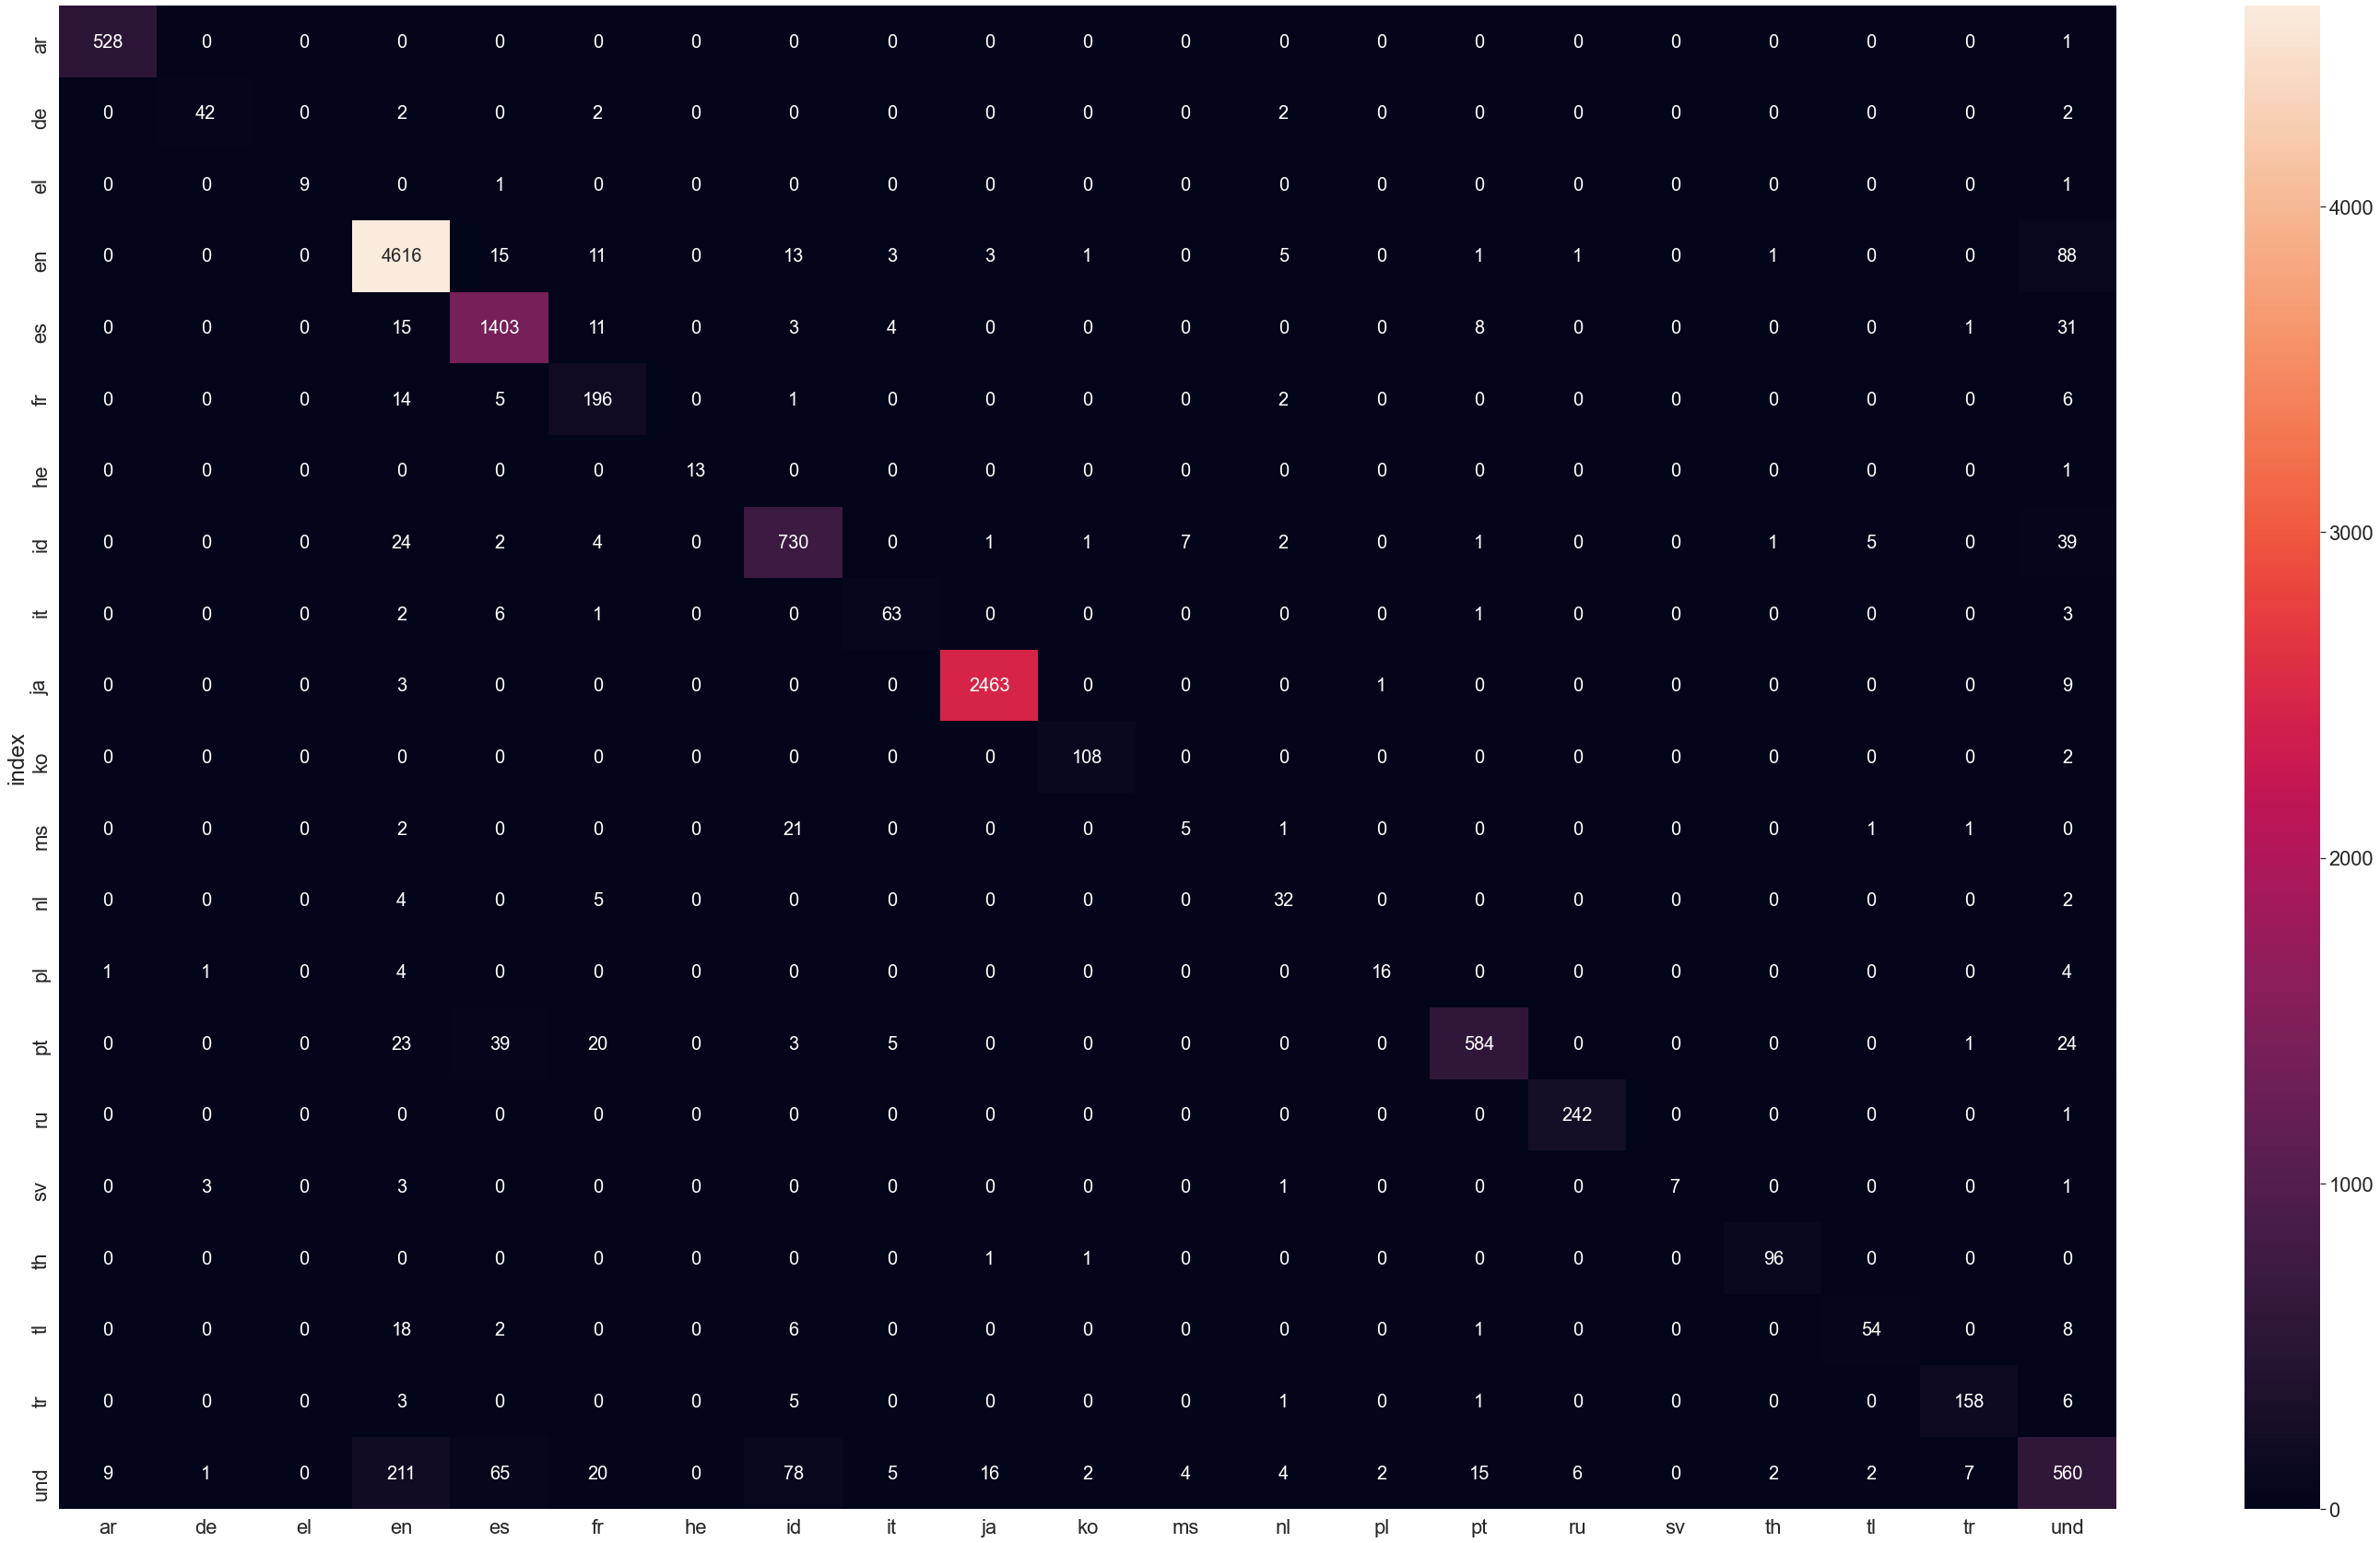

In [ ]:
plt.figure(figsize = (50, 30))
sn.set(font_scale=2) 
sn.heatmap(confusion_matrix_dataframe, annot=True, annot_kws={"size": 20}, fmt='.4g')

## Plotting correlation between Hyperparameters from Talos dataframe

##### Creating a dataframe from talos object and filtering hyperaparameter subset from it

In [ ]:
params_df = t.data
params_df = params_df[['batch_size','dropout', 'filters','hidden_dims', 'kernel_size', 'learning_rate','optimizer','pooling','strides']]

In [ ]:
# changing pooling to a single value since only 1 pooling type used in Talos Scan
params_df['pooling'] = 1

In [ ]:
# function to replace values in the optimizer column with indexes
def replace_optim(x):
  if x == 'Adam':
    return 0
  else:
    return 1

In [ ]:
# applying function to change values of optimizer to indexes and dropping old optimizer column
params_df['optimizer_num'] = params_df['optimizer'].apply(replace_optim)
params_df.drop(columns='optimizer', inplace=True, axis=1)

<AxesSubplot:>

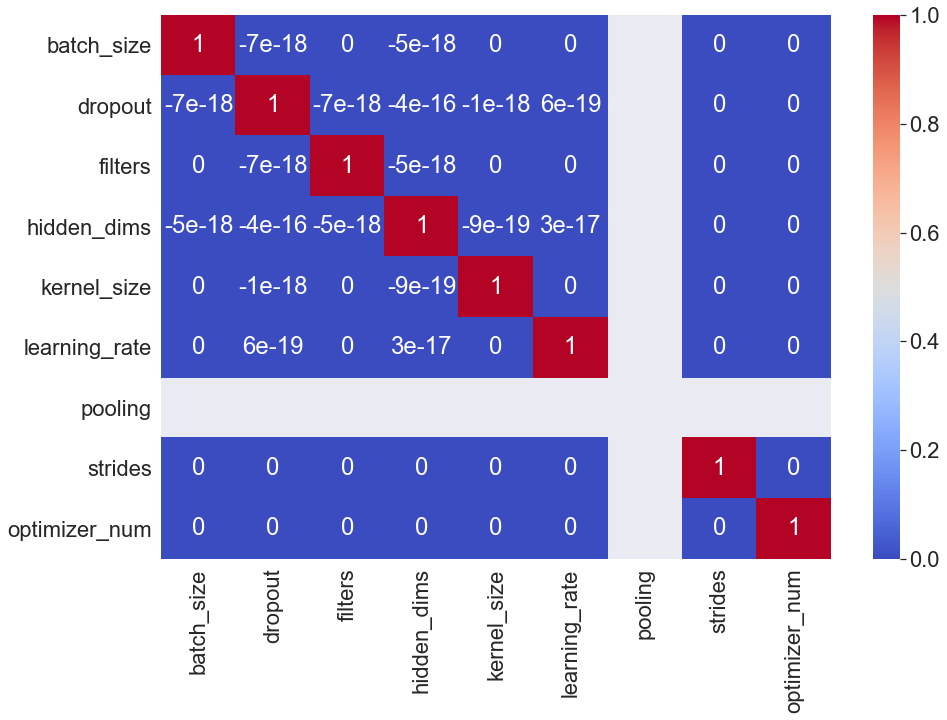

In [ ]:
# plotting correlation plot for hyperparameters
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sn.heatmap(params_df.corr(), annot = True,cmap= 'coolwarm', fmt='.1g')